# Семинар 3. Обнаружение траектории энтропийным алгоритмом SPRT

In [1]:
#@title
#%matplotlib
import time                         # библиотека функций системного времени
import numpy as np                  # библиотека математических функций
from scipy.stats import chi2        # библиотека статистических функций
import matplotlib.pyplot as plt     # библиотека построения графиков

T = 50                             # продолжительность траектории
dt = 1                              # шаг дискретизации траектории
time_series = np.arange(1,T,dt)     # отсчеты времени

F = np.array(   [[1.0,  dt],        # матрица перехода текущего состояния в будущее
                [0.0,  1.0]])
G = np.array([dt**2/2, dt])         # матрица связи возмущающего воздействия с вектором состояния объекта

X = np.array([0,10])                # начальное значение вектора состояния объекта

process_noise = 1                   # СКО возмущающего воздействия
np.random.seed(0)                   # выбор случайной последовательности

X_log = {'time':[0], 'state':[X]}   # сохранение данных для отображения
for t in time_series:
    ax = np.random.normal(0,process_noise)
    X = F@X + G*ax
    X_log['time'].append(t)
    X_log['state'].append(X)

x = [X_log['state'][i][0] for i in range(len(X_log['state']))]  # выборка комопненты 'х' ~ [0] из вектора состояния

H = [1, 0]
sigma = 30
z_log = []
for i in range(len(X_log['state'])):
    e = np.random.normal(0, sigma)
    z = H@X_log['state'][i] + e
    z_log.append(z)



## Эллиптическое стробирование

* Целью стробирования является уменьшение числа пар Траектория-Измерение для последующей задачи отождествления измерения и фильтрации.
$$
\begin{equation*}
(z^i_k-\hat{z}^x_{k\mid k-1})^T S^{-1}_{k\mid k-1} (z^i_k-\hat{z}^x_{k\mid k-1}) \lessgtr \gamma_G
\end{equation*}
$$
* где $\gamma_G$ порог стробирования
* при эллиптическом стробировании при совпадении модели измерений и модели движения цели невязка будет распределена по нормальному закону
$$
\begin{equation*}
\Delta{z}_k = z_k - \hat{z}_{k\mid k-1} \sim \mathcal{N} (0,S_{k\mid k-1})
\end{equation*}$$

* Статистика $\Delta{z}_k^T S_{k\mid k-1}^{-1} \Delta{z}$ будет подчинена $\chi^2$ распределению
* Для нахождения порога стробирования надо найти квантиль по заданному уровню вероятности $P_G$ и числу степеней свободы $n$, равному размерности вектора измерений

Для отображения эллиптического строба на плоскотси выполните следующий код

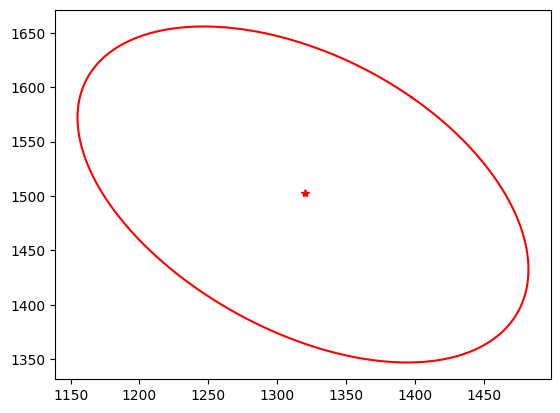

In [6]:
# процедура отображения строба вокруг предсказанного измерения
def plot_strobe(ze, Se, Pg = 0.99):
    plt.plot(ze[0]*np.cos(ze[1]),ze[0]*np.sin(ze[1]),'*r')  # текущее предсказанное измерение
    phi = np.linspace(0,2*np.pi,720)                        # перебор возможных направлений измерений
    cosxy = np.stack((np.cos(phi),np.sin(phi))) # расчет поврота орта
    gamma = chi2.ppf(q = Pg, df = 2)         # расчет границы по уровню вероятности Pg
    U = np.linalg.cholesky(Se)
    gz = np.tile(np.reshape(ze,(-1,1)),(1,720)) # копрование массив для корректного матричного суммирования
    g = gz + np.sqrt(gamma)*U@cosxy        # вычисляем координаты границ строба
    # добавляем пересчет в декартову СК
    x = g[0][0:]*np.cos(g[1][0:])
    y = g[0][0:]*np.sin(g[1][0:])
    plt.plot(x,y,'r')
    
plot_strobe(np.array([2000,0.85]),np.array([[1500,0],[0,1e-3]]),Pg = 0.99) # проверка рисования строба

# Задание №1.

Постройте эллиптические стробы соответствующие вероятности попадания в строб $P_g = 0.5, 0.8, 0.9$.

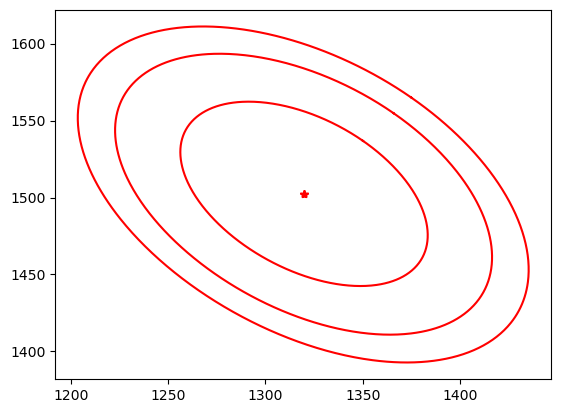

In [7]:
plot_strobe(np.array([2000,0.85]),np.array([[1500,0],[0,1e-3]]),Pg = 0.5) # проверка рисования строба
plot_strobe(np.array([2000,0.85]),np.array([[1500,0],[0,1e-3]]),Pg = 0.8) # проверка рисования строба
plot_strobe(np.array([2000,0.85]),np.array([[1500,0],[0,1e-3]]),Pg = 0.9) # проверка рисования строба

## Энтропийный (SPRT) алгоритм обнаружения траектории цели
* Основан на вычислении отношения апостериорных вероятностей гипотез $\Lambda_k$ о множестве измерений $z_{0:k}$
* Инициализация траектории в момент $k=0$ должна происходить из выражения
$$ \Lambda_0 = 0 $$
* При попадании очередного измерения в строб траектории увеличить отношения апостериорных вероятностей гипотез $\Lambda_k$
$$\Lambda_k = \Lambda_{k-1} + \ln\left(\frac{P_D\cdot p_{k|k-1}( z_k)}{\beta_{FA}}\right)$$
* $P_D$ - вероятность правильного обнаружения цели в стробе 
* $p_{k|k-1}(y_k) = \mathcal{N}(y_k;\hat{y}_{k\mid k-1}; S_{k\mid k-1})$ вероятность появления измерения при гауссовской модели случайных отсчетов (правдоподобие отсчета)

* При пропуске измерения на очередном такте вторичной обработки скорректикровать $\Lambda_k$
$$ \Lambda_k=\Lambda_{k-1}+\ln(1-P_D P_G)$$
*  $P_G$ - вероятность правильного стробирования, заданная пользователем и использованная для выставления порога $\gamma_G$

* Для принятия решения об обнаружении пользователь должен задать вероятности обнаружения ложной траектории $P_{FC}$ (false confirmation, ложное обнаружение траектории) и вероятности пропуска траектории $P_{TM}$ (track miss, пропуск траектории), а пороги получить из соотношений
$$\gamma_{high} = \ln \frac{1-P_{TM}}{P_{FC}} = \ln \frac{P_{обн.ПТ}}{P_{обн.ЛТ}}$$
$$\gamma_{low} = \ln \frac{P_{TM}}{1-P_{FC}} = \ln \frac{P_{пропуск.ПТ}}{P_{пропуск.ЛТ}}$$
* $\Lambda_k\geq \gamma_{high}$ - траектория обнаружения, верна гипотеза $\mathcal{H}_1$
* $ \Lambda_k\leq \gamma_{low}$ - сброс завязываемой траектории, верна гипотеза $\mathcal{H}_0$ 
* $ \gamma_{low} \leq \Lambda_k\leq \gamma_{high}$ - не достаточно информации о принятии решения, траектория остается на завязке

# Задание   №2

Создайте класс траектории, включающий фильтр траекторных параметров из 2 семинара, процедуру стробирования и отображения строба. 
Подайте на вход объекта траектории измерения из первого семинара и отобразите график изменения. Определите, на каком такте произойдет принятие решения об обнаружении траектории при заданных параметрах $P_{tm} = 0.1, P_{fc} = 0.01, P_D = 0.9, P_G = 0.99, \beta_{FA} = 10^{-6}$. Как надо изменить параметры, чтобы обнаружение произошло раньше.

## Модель движения 2D CV

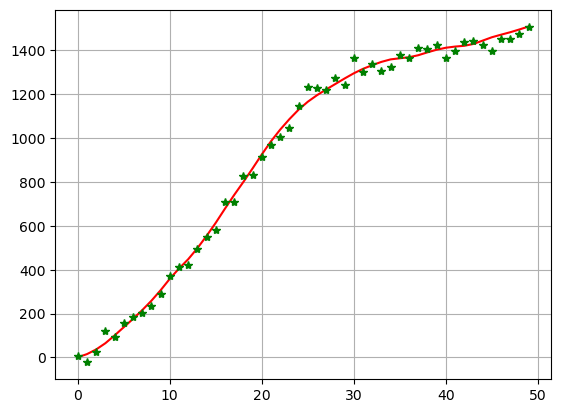

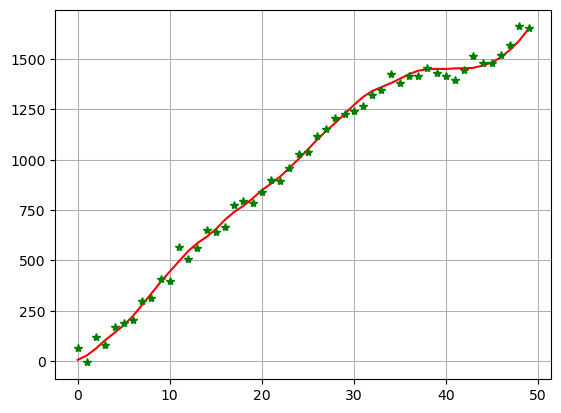

In [8]:
# напишите свой код в этом блоке

T = 50                              # продолжительность траектории
dt = 1                              # шаг дискретизации траектории
time_series = np.arange(1, T, dt)     # отсчеты времени

FPolar = np.array( [[1.0,  dt, 0.0, 0.0],
                    [0.0, 1.0, 0.0, 0.0],
                    [0.0, 0.0, 1.0,  dt],
                    [0.0, 0.0, 0.0, 1.0]])

GPolar = np.array( [[dt**2/2,   0.0],
                    [dt,        0.0],
                    [0.0,   dt**2/2],
                    [0.0,   dt     ]])

XPolar= np.array(   [[1.0],     # X
                     [10.0],    # Vx
                     [6.0],     # y
                     [20.0]])   # Vy
process_noise1 = 5                   # СКО возмущающего воздействия
process_noise2 = 10
np.random.seed(0)                   # выбор случайной последовательности

X_log = {'time':[0], 'state':[XPolar]}   # сохранение данных для отображения
for t in time_series:
    ax1 = np.random.normal(0, process_noise1, 1)
    ax2 = np.random.normal(0, process_noise2, 1)
    ax3 = np.array((ax1.item(), ax2.item())).reshape(2,1)
    XPolar = FPolar@XPolar + GPolar@ax3
    X_log['time'].append(t)
    X_log['state'].append(XPolar)

x  = np.array([X_log['state'][i][0] for i in range(len(X_log['state']))]).squeeze()  # выборка комопненты 'х'  ~ [0] из вектора состояния
Vx = np.array([X_log['state'][i][1] for i in range(len(X_log['state']))]).squeeze()  # выборка комопненты 'Vx' ~ [1] из вектора состояния
y  = np.array([X_log['state'][i][2] for i in range(len(X_log['state']))]).squeeze()  # выборка комопненты 'y'  ~ [2] из вектора состояния
Vy = np.array([X_log['state'][i][3] for i in range(len(X_log['state']))]).squeeze()  # выборка комопненты 'Vy' ~ [3] из вектора состояния


H = np.array([[1.0, 0.0, 0.0, 0.0],
              [0.0, 1.0, 0.0, 0.0],
              [0.0, 0.0, 1.0, 0.0],
              [0.0, 0.0, 0.0, 1.0]])
sigma = 30

z_log = []
for i in range(len(X_log['state'])):
    e = np.random.normal(0, sigma, (4,1))
    z = H@X_log['state'][i] + e
    z_log.append(z)
z_log = np.array(z_log).squeeze()
m = z_log[:,2]
plt.figure()
plt.plot(X_log['time'], x, 'r',
         X_log['time'], z_log[:,0], '*g')
plt.grid()

plt.figure()
plt.plot(X_log['time'], y, 'r',
         X_log['time'], z_log[:,2], '*g')
plt.grid();

# Фильтр Калмана (обычный)

In [9]:
class KalmanFilter2D():

    def __init__(self, sigma_ax, sigma_ay, measurement_noise_rms):
        # предсказанные значения вектора состояния
        self.predictedState = {'Xe':[], 'Pe':[], 'Se':[], 'K':[],'ze':[]}  
        # полученная оценка вектора состояния
        self.correctedState = {'X':[],'P':[]}
        self.settings = {'sigma_ax':sigma_ax, 'sigma_ay':sigma_ay, 'sigma_z':measurement_noise_rms}
        self.F = []
        self.K = []
        self.H = []
        
    def cv(self, X, P, dt):
        sax = self.settings['sigma_ax']
        say = self.settings['sigma_ay']
        F = np.array(  [[1.0,  dt, 0.0, 0.0],
                        [0.0, 1.0, 0.0, 0.0],
                        [0.0, 0.0, 1.0,  dt],
                        [0.0, 0.0, 0.0, 1.0]])
        self.F = F
        G = np.array(  [[dt**2/2,   0.0],
                        [dt,        0.0],
                        [0.0,   dt**2/2],
                        [0.0,   dt     ]])
        
        Q = np.array(  [[sax**2,    0  ],
                        [  0,    say**2]])
        Xe = F@X
        Pe = (F@P)@np.transpose(F)+(G@Q)@np.transpose(G)
        return (Xe,Pe)
        
    def hcv(self,Xe,Pe):
        sz = self.settings['sigma_z']
        H = np.array(  [[1.0, 0.0, 0.0, 0.0],
                        [0.0, 1.0, 0.0, 0.0],
                        [0.0, 0.0, 1.0, 0.0],
                        [0.0, 0.0, 0.0, 1.0]])
        self.H = H
        R = np.array(  [[sz**2,   0,       0,     0   ],
                        [  0,   sz**2,     0,     0   ],
                        [  0,     0,     sz**2,   0   ],
                        [  0,     0,       0,   sz**2 ]]) # TODO: возможно sigma_z надо "растянуть" 
        ze = H@Xe
        Se = (H@Pe)@np.transpose(H)+R
        return (ze,Se,H)

    def predict(self, state_model, measurement_model, X, P, dt):
        (Xe,Pe) = state_model(X,P,dt)
        (ze,Se,H) = measurement_model(Xe,Pe)
        K = (Pe@np.transpose(H))@np.linalg.inv(Se)
        self.K = K
        self.predictedState['Xe'] = Xe
        self.predictedState['Pe'] = Pe
        self.predictedState['ze'] = ze
        self.predictedState['Se'] = Se
        self.predictedState['K'] = K
        
        return (Xe,Pe,ze,Se)
    
    def correct(self,z):
        Xe = self.predictedState['Xe']
        Pe = self.predictedState['Pe']
        ze = self.predictedState['ze']
        Se = self.predictedState['Se']        
        K = self.predictedState['K']
        X = Xe + K@(z-ze)
        P = Pe - (K@Se)@np.transpose(K)
        self.correctedState['X'] = X
        self.correctedState['P'] = P
        return (X,P)

# Фильтрация траектории

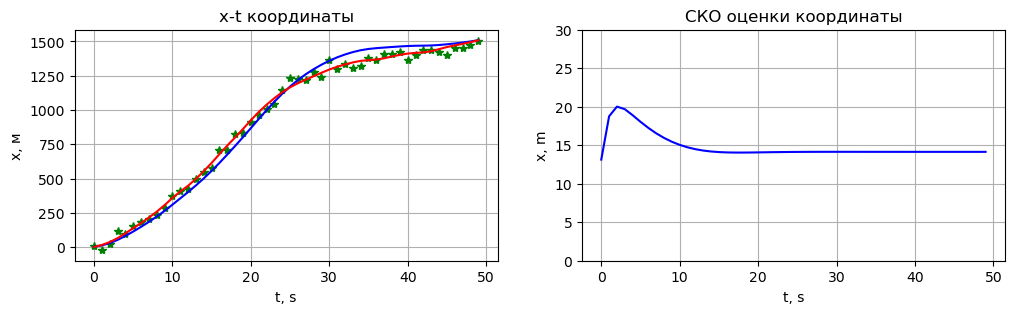

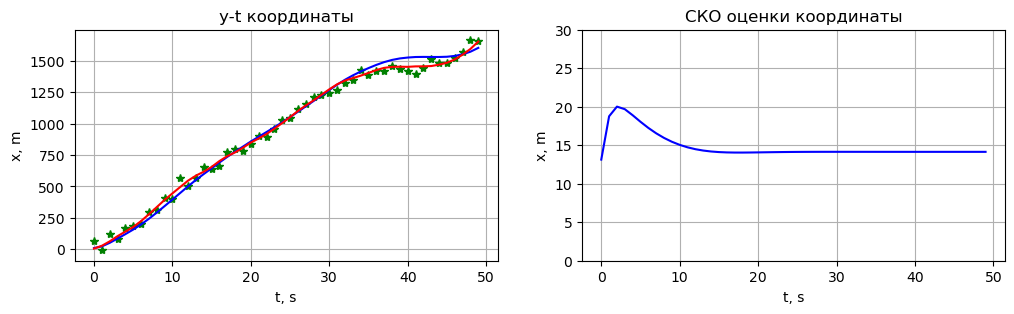

In [10]:
vmax = 50                   # априорные сведения о максимальной скорости движения цели
kappa = 3                   # коэффициент расширения

SV = (vmax/kappa)

sz = 30     # СКО измерений 
sa = 1      # СКО модели оцениваемого процесса (sigma ax, ay)

kf2 = KalmanFilter2D(sa, sa, sz)

xf2 = []  # массив отфильтрованных координат x,y
Pf2 = []  # массив ско отфильтрованных координат x,y
phif = []
Ppf2 = []        

dt = 1   # темп получения измерений

# цикл по тактам траекторной обработки содержащим массивы измерений

for i in range(len(x)):
    z = np.array(  [x[i], 
                    Vx[i], 
                    y[i], 
                    Vy[i]]).reshape(4,1)    # считанное измерение за такт ТО
    if i == 0:
        # процедура инициализации вектора состояния
        X2 = np.array([z[0].item(), # rho
                      0,    # v_rho
                      z[2].item(), # phi
                      0]    # v_phi
                      ).reshape(4,1)  
        
        P2 = np.array([[sa**2,   0,     0,     0  ],
                      [  0,   SV**2,   0,     0  ],
                      [  0,     0,   sa**2,   0  ],
                      [  0,     0,     0,   SV**2 ]])
   
    
    # предсказываем положение цели на сопровождении за такт ТО
    (Xe2,Pe2,ze2,Se2) = kf2.predict(kf2.cv, kf2.hcv, X2, P2, dt)
    
    # коррекция траекторий по результатам отождествления
    (X2,P2) = kf2.correct(z)
    
    # сохранение данных для отображения
    xf2.append(X2[0])
    phif.append(X2[2])         
    Pf2.append(np.sqrt(P2[0][0]))
    Ppf2.append(np.sqrt(P2[2][2]))
    
# рисуем оценку
fig2, (ax11, ax12) = plt.subplots(1,2, figsize=(12,3))
# текущее измерение и отфильтрованная координата, исходные данные

ax11.plot(  X_log['time'], z_log[:,0], '*g', 
            X_log['time'], xf2, 'b', 
            X_log['time'], x, 'r')

ax11.grid(), ax11.set_title('x-t координаты'), ax11.set_xlabel('t, s'), ax11.set_ylabel('x, м')

ax12.plot(X_log['time'], Ppf2, 'b')
ax12.grid(), ax12.set_title('СКО оценки координаты'), ax12.set_xlabel('t, s'), ax12.set_ylabel('x, m')
ax12.set_ylim(0,30)


fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,3))
# текущее измерение и отфильтрованная координата, исходные данные

ax1.plot(   X_log['time'], z_log[:,2], '*g', 
            X_log['time'], phif, 'b', 
            X_log['time'], y, 'r')
ax1.grid(), ax1.set_title('y-t координаты'), ax1.set_xlabel('t, s'), ax1.set_ylabel('x, m')

ax2.plot(X_log['time'], Pf2, 'b')
ax2.grid(), ax2.set_title('СКО оценки координаты'), ax2.set_xlabel('t, s'), ax2.set_ylabel('x, m')
ax2.set_ylim(0,30)
pass

xf2 = np.array(xf2).squeeze()
phif = np.array(phif).squeeze()

rho_filtered = np.sqrt(xf2**2 + phif**2)
phi_filtered = np.arctan2(phif, xf2)

# Энтропийный алгоритм собственной персоной

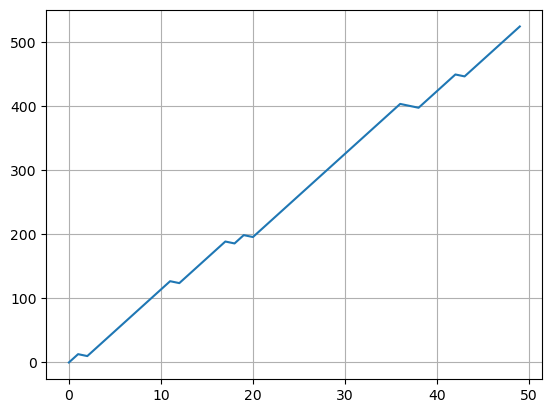

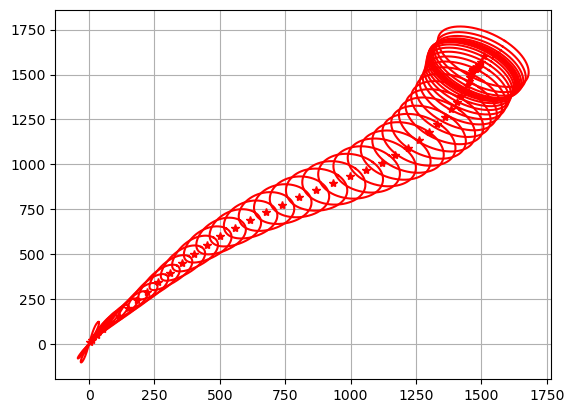

In [11]:
P_tm = 0.1
P_fc = 0.01
P_d = 0.9
P_g = 0.99
beta_fa = 1e-6

gamma_high = np.log((1-P_tm)/P_fc) 
gamma_low  = np.log(P_tm/(1-P_fc)) 
Lambda0 = np.array([0]*len(z_log))

z_real = []
z_miss = []
Pd = 0.8
for i in range(len(z_log)):
    if i == 0:
        continue
    
    if np.random.uniform() < P_d:
        Lambda0[i] = Lambda0[i-1] + np.log(P_d*1/beta_fa)
    else:
        Lambda0[i] = Lambda0[i-1] + np.log(1 - P_d*P_g)

plt.plot(Lambda0)
plt.grid();

plt.figure()
for i in range(len(rho_filtered)):
    plot_strobe(np.array([rho_filtered[i], phi_filtered[i]]), 
                np.array([[1500,0],[0,1e-3]]), 
                P_g );
plt.grid()